In [35]:
# Fight Picker
## Tyler Aden

## Introduction

This is the workflow for a fight prediction application. This notebook includes:

* Introduction
    * Background
    * Objective
* Data Requirements
    * Web Scraping
    * Data Cleansing and Blending
    * Finalized Dataset
* Libraries Used
* EDA
    * Statistical Overview
    * Heatmap and Correlation
    * Statistical Tests
    * Distribution Plots
* Feature Selection
    * Feature Significance
* Modelling the Data
    * Logistical Regression
    * Random Forest
    * Neural Network
* Conclusion
* Improvements
* Citation

## Background

The idea is to generate more realistic betting odds between an **Favorite** and an **Underdog** to gain an edge over Vegas and to discover insights that experts may have missed.

## Objective
The objective of this project is to build a model that:
* Predicts better than 50% accuracy
* Predicts better than choosing strictly favorites

Further analysis on betting odds vs model performance to also be done.

## Data Requirements

Two datasets are needed and scraped from public sources:

### UFC Fighters Database

[Dataset](http://www.fightmetric.com/statistics/fighters) that contains fight stats for all UFC fighters

### Dataset preview

In [36]:
import pandas as pd
fighter_db = pd.read_csv('https://raw.githubusercontent.com/tkaden/FightPicker/master/data/UFC_Fighters_Database.csv')
fighter_db.head()

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

## Fight History

We need a dataset that contains the fight odds as that will be one of the most important variables in our analysis.

Odds are available at www.betmma.tips and is a highly valuable resource for statistics as well. Additionally, fightmetric.com is another great resource.

Source(s):
* http://www.fightmetric.com/statistics/events/completed
* http://www.betmma.tips/mma_betting_favorites_vs_underdogs.php

This project will also include web scraping code to gather this data and clean it.

In [ ]:
fights_db = pd.read_csv('https://raw.githubusercontent.com/tkaden/FightPicker/master/data/UFC_Fights.csv')
fights_db.head()

,RecordID,Events,Fighter1,Fighter2,Winner,fighter1_odds,fighter2_odds,F1 or F2,Label,Combine,Favourite,Underdog
0,1,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Jon Jones,1.13,9.00,1,Favourite,Favourite 1,Jon Jones,Chael Sonnen
1,2,UFC 159 - Jones vs. Sonnen,Michael Bisping,Alan Belcher,Michael Bisping,1.57,4.50,1,Favourite,Favourite 1,Michael Bisping,Alan Belcher
2,3,UFC 159 - Jones vs. Sonnen,Roy Nelson,Cheick Kongo,Roy Nelson,1.43,3.20,1,Favourite,Favourite 1,Roy Nelson,Cheick Kongo
3,4,UFC 159 - Jones vs. Sonnen,Phil Davis,Vinny Magalhaes,Phil Davis,1.36,3.55,1,Favourite,Favourite 1,Phil Davis,Vinny Magalhaes
4,5,UFC 159 - Jones vs. Sonnen,Pat Healy,Jim Miller,Pat Healy,3.40,1.40,1,Underdog,Underdog 1,Jim Miller,Pat Healy


## Data Cleansing and Blending

The two datasets above were cleansed and blended together using the following process.

### Feature Mapping

Note that for each feature `x`. It is the difference between the Favourite vs Underdog. Hence if the feature is positive, this implies the favourite fighter has an advantage over the underdog for that feature.



$Feature\quad { X }_{ i }=\quad { X }_{ favourite }\quad -\quad { X }_{ underdog }$

## Finalized Dataset

The following are the response variable and 10 features used in the dataset. Note that each feature has a suffix of **delta** due to the fact that it undergone the feature mapping stated above.

* Label - This is the response variable. Either Favourite or Underdog will win
* REACH - Fighter's reach. (Probabaly the least important feature)
* SLPM - Significant Strikes Landed per Minute
* STRA. - Significant Striking Accuracy
* SAPM - Significant Strikes Absorbed per Minute
* STRD - Significant Strike Defence (the % of opponents strikes that did not land)
* TD - Average Takedowns Landed per 15 minutes
* TDA - Takedown Accuracy
* TDD - Takedown Defense (the % of opponents TD attempts that did not land)
* SUBA - Average Submissions Attempted per 15 minutes
* Odds - Fighter's decimal odds spread for that specific matchup

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tkaden/FightPicker/master/data/Cleansed_Data.csv')
df = df.drop('Sum_delta', axis=1)
df.head()

,Events,Favourite,Underdog,Label,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
0,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Favourite,10,1.17,0.90,0.12,0.03,-1.56,-0.07,0.28,0.2,-7.87
1,UFC 159 - Jones vs. Sonnen,Leonard Garcia,Cody McKenzie,Underdog,-3,1.03,2.29,-0.10,-0.15,-2.20,0.01,0.28,-2.0,1.40
2,UFC Fight Night 34 - Saffiedine vs. Lim,Mairbek Taisumov,Tae Hyun Bang,Favourite,2,0.54,0.08,0.05,-0.05,1.75,0.44,0.28,-0.5,-2.89
3,UFC Fight Night 91 - McDonald vs. Lineker,Cody Pfister,Scott Holtzman,Underdog,4,-3.15,-0.85,-0.24,-0.06,0.55,-0.27,-0.58,-0.4,6.89
4,UFC Fight Night 91 - McDonald vs. Lineker,Matthew Lopez,Rani Yahya,Underdog,2,0.02,0.86,0.13,-0.06,-0.08,0.51,0.37,-0.5,0.81


## Librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

#Progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Creating Dummies
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

## Exploritory Data Analysis (EDA)

### Statistical Overview

From the *finalized dataset*, we know that: 

1. 1,315 rows which implies the number of historical fights in the dataset
2. rougly 62% of Favourite fighters win over Underdogs
3. On average, Favourites that win have all features advantage compared to the underdog. They get hit less and are more accurate with their striking, making Favourite winners more efficient over Underdog winners
4. Meanwhile Underdog winner historically end up taking more hits and less efficient on average but somehow end up winning. Could this be luck from landing a sudden KO or submission?


In [ ]:
# Shape of df
df.shape

(1315, 14)

In [ ]:
# Data types
df.dtypes

Events          object
Favourite       object
Underdog        object
Label           object
REACH_delta      int64
SLPM_delta     float64
SAPM_delta     float64
STRA_delta     float64
STRD_delta     float64
TD_delta       float64
TDA_delta      float64
TDD_delta      float64
SUBA_delta     float64
Odds_delta     float64
dtype: object

In [ ]:
# What percentage of Favourite fighters win?
df['Label'].value_counts()
fav_win = df['Label'].value_counts()/len(df)
fav_win

Favourite    0.627376
Underdog     0.372624
Name: Label, dtype: float64

In [ ]:
perc = df['Label'].value_counts()/len(df)
perc

Favourite    0.627376
Underdog     0.372624
Name: Label, dtype: float64

<AxesSubplot:>

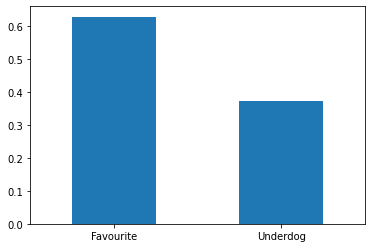

In [ ]:
perc.plot(kind='bar', rot=0)

In [ ]:
# Statistical overview of dataset
df.describe()

,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
count,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,0.219011,0.264205,-0.302084,0.013338,0.017886,0.280897,0.052259,0.055749,0.103194,-0.859810
std,3.321775,1.475753,1.571591,0.111590,0.104947,1.886774,0.286079,0.299480,1.173894,2.313673
min,-10.000000,-6.020000,-10.560000,-0.490000,-0.350000,-10.750000,-1.000000,-1.000000,-12.100000,-12.950000
25%,-2.000000,-0.620000,-1.110000,-0.060000,-0.050000,-0.900000,-0.120000,-0.120000,-0.500000,-1.940000
50%,0.000000,0.300000,-0.200000,0.010000,0.020000,0.240000,0.040000,0.040000,0.000000,-0.780000
75%,2.000000,1.175000,0.605000,0.080000,0.090000,1.365000,0.225000,0.230000,0.600000,0.575000
max,12.000000,7.480000,7.910000,0.570000,0.420000,9.780000,1.000000,1.000000,11.800000,7.380000


array([[<AxesSubplot:title={'center':'REACH_delta'}, xlabel='Label'>,
        <AxesSubplot:title={'center':'SLPM_delta'}, xlabel='Label'>],
       [<AxesSubplot:title={'center':'SAPM_delta'}, xlabel='Label'>,
        <AxesSubplot:title={'center':'STRA_delta'}, xlabel='Label'>],
       [<AxesSubplot:title={'center':'STRD_delta'}, xlabel='Label'>,
        <AxesSubplot:title={'center':'TD_delta'}, xlabel='Label'>],
       [<AxesSubplot:title={'center':'TDA_delta'}, xlabel='Label'>,
        <AxesSubplot:title={'center':'TDD_delta'}, xlabel='Label'>],
       [<AxesSubplot:title={'center':'SUBA_delta'}, xlabel='Label'>,
        <AxesSubplot:title={'center':'Odds_delta'}, xlabel='Label'>]],
      dtype=object)

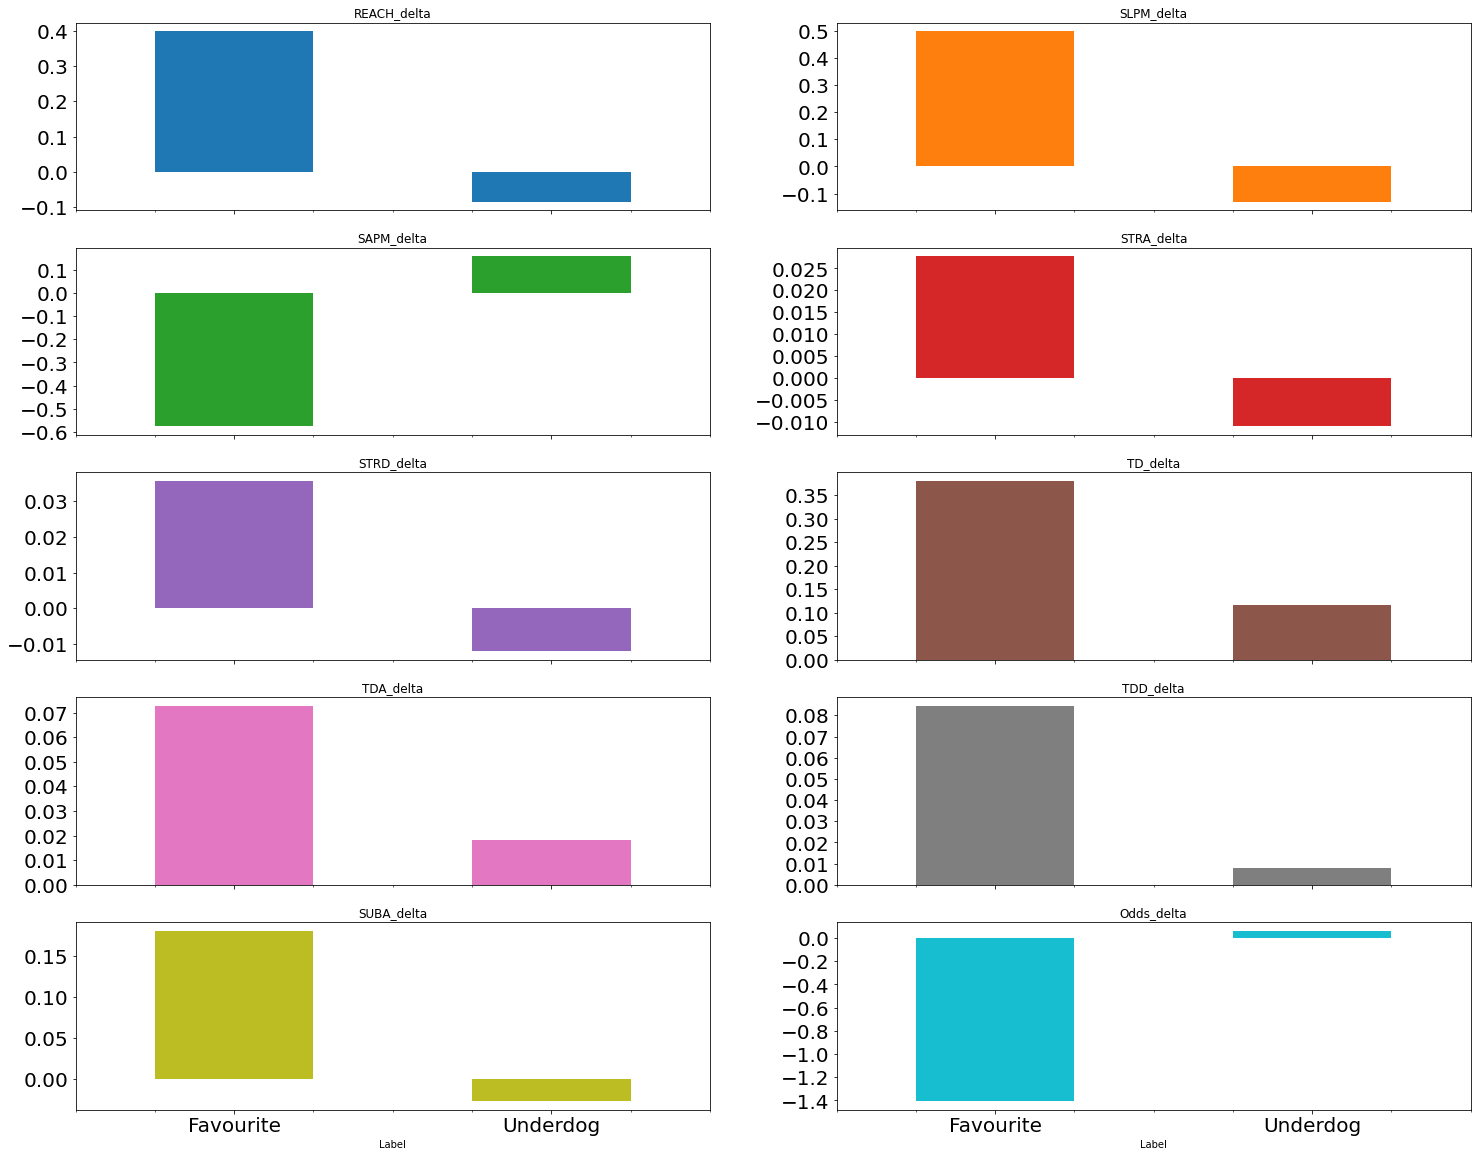

In [ ]:
# Does mean of each feature distinguish the Favourite / Underdog to win ?
# Does a specific feature advantage give the underdog winners an edge ?
df.groupby('Label').mean().plot(kind = 'bar', subplots=True, layout=(5,2), legend=False, figsize=(25,20), fontsize=20, rot=0)

### Correlation Matrix and Heatmap

From the correlation matrix, we know that:

1. Predictors are not too correlated with each other. Low possibility of multicollinearity. Not too much of a worry if regression is applied
1. Positive correlation to strikes landed, striking defense to make a favourite more favourable to win

In [ ]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

# Correlation Matrix
df_corr = create_dummies(df, 'Label').drop('Label_Underdog', axis = 1)
corr = df_corr.corr()
corr = (corr)
corr

,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta,Label_Favourite
REACH_delta,1.000000,0.037076,-0.077292,-0.042400,-0.090796,-0.078721,0.027693,-0.072749,0.060381,-0.030485,0.070252
SLPM_delta,0.037076,1.000000,0.089550,0.361854,0.268306,-0.167199,0.041915,0.195507,-0.167117,-0.154969,0.205441
SAPM_delta,-0.077292,0.089550,1.000000,-0.298355,-0.412943,-0.280762,-0.230730,-0.064397,-0.040124,0.148382,-0.226802
STRA_delta,-0.042400,0.361854,-0.298355,1.000000,0.114704,0.202333,0.246022,0.143988,0.038443,-0.103734,0.168435
STRD_delta,-0.090796,0.268306,-0.412943,0.114704,1.000000,0.043988,0.128065,0.188816,-0.153664,-0.111798,0.220450
TD_delta,-0.078721,-0.167199,-0.280762,0.202333,0.043988,1.000000,0.427436,0.003178,0.192474,-0.072800,0.067313
TDA_delta,0.027693,0.041915,-0.230730,0.246022,0.128065,0.427436,1.000000,0.221375,0.098257,-0.106092,0.091885
TDD_delta,-0.072749,0.195507,-0.064397,0.143988,0.188816,0.003178,0.221375,1.000000,-0.157317,-0.101961,0.123448
SUBA_delta,0.060381,-0.167117,-0.040124,0.038443,-0.153664,0.192474,0.098257,-0.157317,1.000000,-0.047820,0.085332
Odds_delta,-0.030485,-0.154969,0.148382,-0.103734,-0.111798,-0.072800,-0.106092,-0.101961,-0.047820,1.000000,-0.306930


<AxesSubplot:>

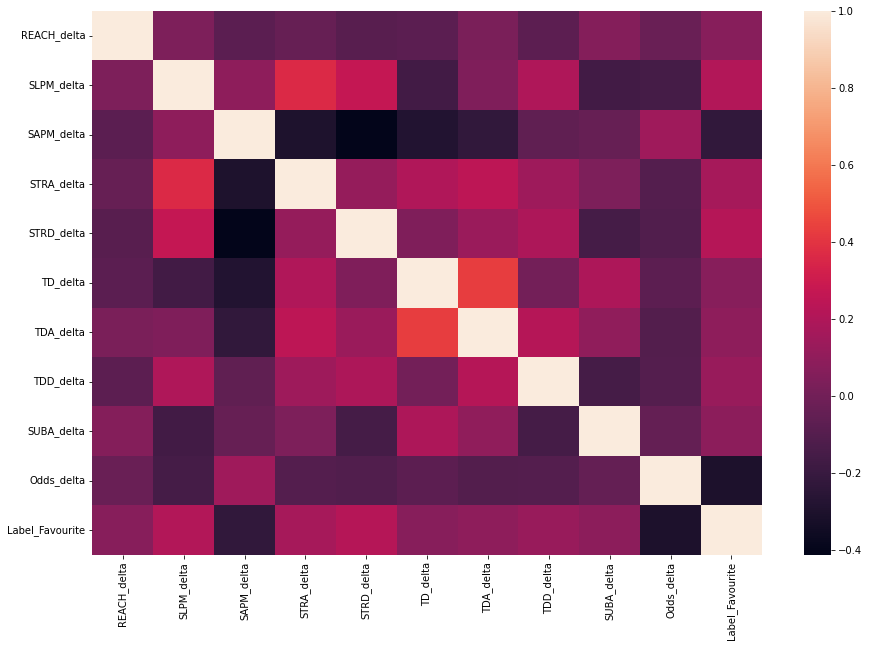

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### One Sample T-test (Measuring STRD_delta)

A one-sample t-test checks whether a sample mean differs from the population mean. Since STRD_delta has the highest correlation with the dependent variable 'Label_Favourite', let's test to see whether the average STRD_delta of Favourite and Underdog winners differs significantly.

Hypothesis Testing: Is there significant difference in the means of STRD_delta between favourite winners and underdog winners?

# Compating both means

print('STRD_delta mean of favourite winners is: ' +  '{}' .format(df['STRD_delta'][df['Label'] == 'Favourite'].mean()))
print('STRD_delta mean of undersog winners is: ' + '{}'.format(df['STRD_delta'][df['Label'] == 'Underdog'].mean()))

# However, is the marginal difference of 0.047 significant? 

In [ ]:
print('STRD_delta mean of favorite winners is: ' +  '{}' .format(df['STRD_delta'][df['Label'] == 'Favourite'].mean()))
print('STRD_delta mean of underdog winners is: ' + '{}'.format(df['STRD_delta'][df['Label'] == 'Underdog'].mean()))

STRD_delta mean of favorite winners is: 0.03570909090909091
STRD_delta mean of underdog winners is: -0.012122448979591837


## Conducting the T-test (95% confidence interval)

### Reject the null hypothesis because:

1. T test scores lies outside the quantiles, 4.96 > 1.96

2. P - value lower than 5%

In [ ]:
# T-test
stats.ttest_1samp(a=  df[df['Label']=='Favourite']['STRD_delta'], # Sample of Favourite winners
                  popmean = df['STRD_delta'].mean())  # Fighter population mean 

Ttest_1sampResult(statistic=4.98752556208951, pvalue=7.459987627406544e-07)

In [ ]:
# Critical point 
degree_freedom = len(df[df['Label']=='Favourite'])

LQ = stats.t.ppf(0.025,degree_freedom)  # Left Quartile

RQ = stats.t.ppf(0.975,degree_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(LQ))
print ('The t-distribution right quartile range is: ' + str(RQ))

The t-distribution left quartile range is: -1.962843616296083
The t-distribution right quartile range is: 1.9628436162960825


## Distribution

* In most of the predictors, distribution is relatively normal centered around 0
* This implies most matches made in UFC are based on evenly macthed skillsets
* Note that for the Underdog winners, it seems that the mean for the predictors tend to be lower than Favourites
* This implies Underdog winners are more skilled in that particular area for the matchup but somehow has been labelled as Underdog by wisdom of the crowd (https://www.betmma.tips/mma_betting_statistics.php)

In [ ]:
cols = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis =1).columns.tolist()

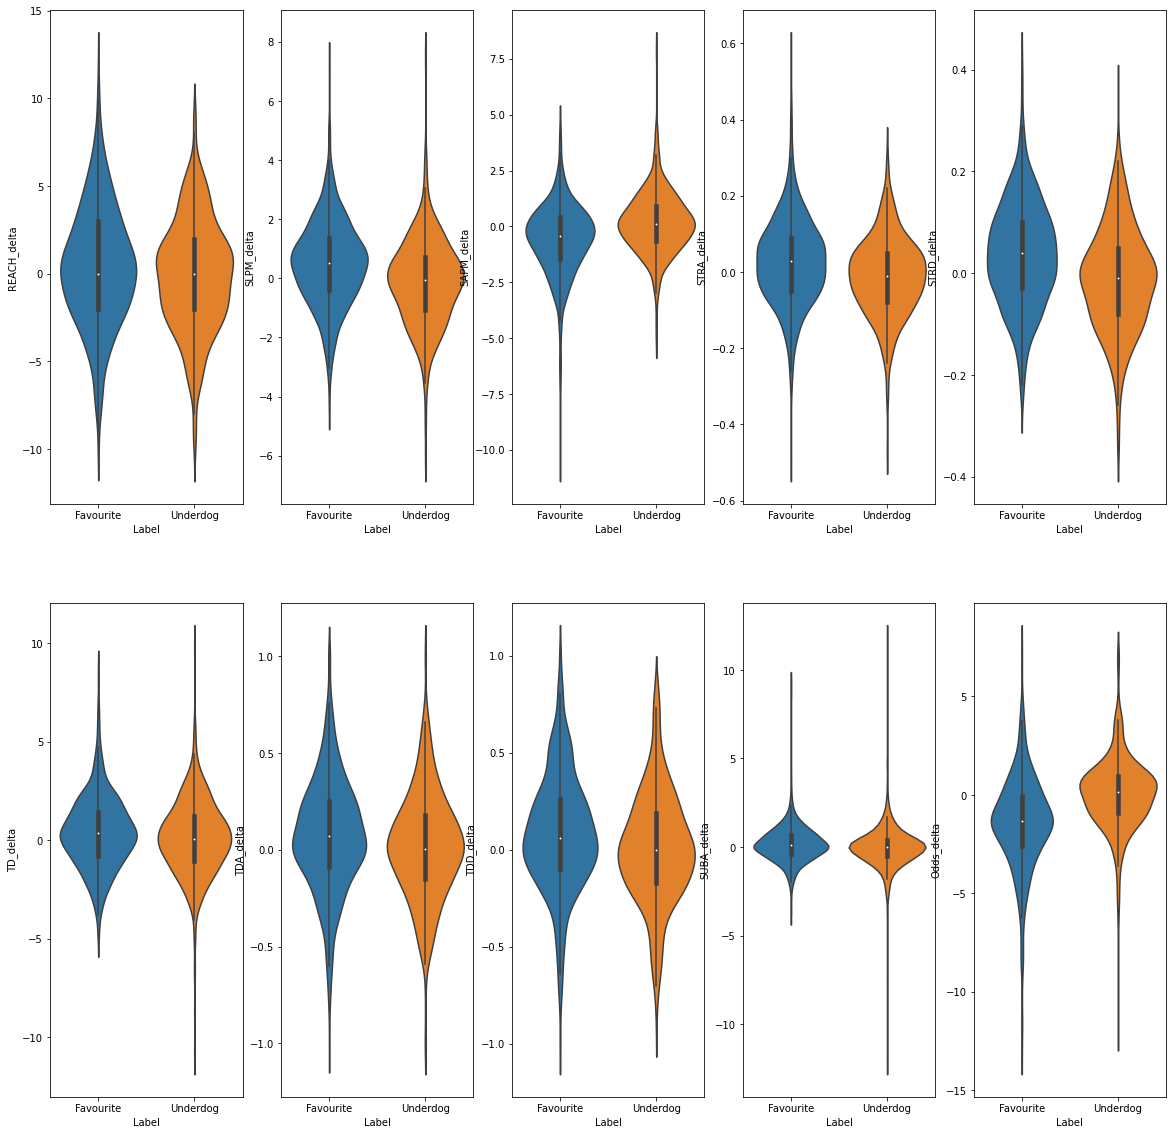

In [ ]:
# create 10 plots with a 2 by 5 dimension subplots
fig, ax = plt.subplots(2,5, figsize=(20,20))

# loop to plot in subplots
for i, col in enumerate(cols):
    x = i // 5
    y = i % 5
    sns.violinplot(x="Label", y=col , data=df, order=["Favourite", "Underdog"], ax=ax[x,y])

## Feature Selection

Feature selection is the process of selecting a subset of relevant predictors for use in model construction. Feature selection is used for:

* simplification of models to make them easier to interpret
* shorter training times (applicable to very huge datasets)
* to avoid the curse of dimensionality 
* enhanced generalization by reducing overfitting (reduction of variance)

From RFECV and Feature Importance as validation, we know:

* The 5 most important features are SAPM_delta, SLPM_delta, STRD_delta, TD_delta, Odds_delta

## Recursive Feature Elimination with Cross Validation (RFECV)

The features will be selected based on Recursive Feature Elimination with Cross Validation (RFECV). Recursive Feature Elimination (RFE) works by training the model, evaluating it, then removing the least significant features, and repeating.

In [ ]:
# Create a function to select features
# Note that feature names are stored in cols

def select_features(df):
    all_X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)
    all_y = df['Label']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns \n' + '-'*12 + '\n' + '{}'.format(best_columns))
    
    return best_columns

In [ ]:
best_cols = select_features(df)

Best Columns 
------------
['REACH_delta', 'SLPM_delta', 'SAPM_delta', 'STRA_delta', 'STRD_delta', 'TD_delta', 'TDA_delta', 'TDD_delta', 'SUBA_delta', 'Odds_delta']


## Feature Importance

As expected Reach_delta is of least importance since reach does not really determine a clear winner

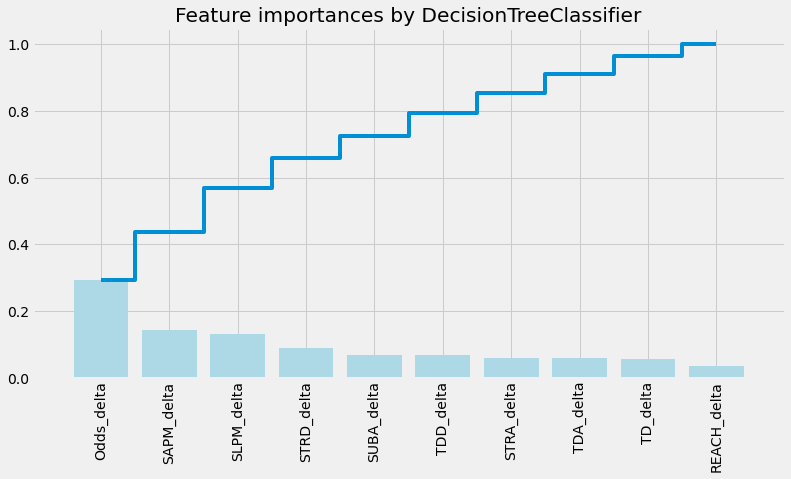

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits
target_name = 'Label'
X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1, stratify=y)

dtree = RandomForestClassifier(
    #max_depth=3,
    random_state = 1,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## Model Selection and Hyperparameter Tuning

* Model selection and hyperparameter tuning were accomplish using GridSearchCV
* There is no need to apply train_test_split in this case due to the Cross Validation embedded in GridSearchCV
* Among the models considered are:
    * Logistic Regression
    * Random Forest Classifier
    * Neural Network (MLP)

In [ ]:
def select_model(df, features):
    
    all_X = df[features]
    all_y = df["Label"]
    #create a list of dics which contains models and hyperparameters
    models = [
        
        {
            "name": "Logistic Regression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
             "solver": ["newton-cg", "lbfgs", "liblinear"]   
            }
            
        },

        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
                {
            "name": "Multi Layer Perceptron (MLP)",
            "estimator": MLPClassifier(random_state=1),
            "hyperparameters":
                {
                    "hidden_layer_sizes": [(5,5), (10,10)],
                    "activation": ["relu", "tanh", "logistic"],
                    "solver": ['sgd', 'adam'],
                    "learning_rate": ["constant", "adaptive"]

                }
        }   
        
    ]
    
    for model in log_progress(models):
        print(model["name"])
        print("-"*len(model["name"]))
        
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, scoring = 'accuracy')
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        model["scoring"] = grid.scorer_
        
        print("Best Paramerters: " + "{}".format(model["best_params"]))
        print("Best Score: " + "{}".format(model["best_score"]))
        print("Best Model: " + "{}".format(model["best_model"]))
        print("Scoring method: " + "{}\n".format(model["scoring"]))
        
    return models

In [ ]:
models = select_model(df, best_cols)

Logistic Regression
-------------------
Best Paramerters: {'solver': 'newton-cg'}
Best Score: 0.7010929909784871
Best Model: LogisticRegression(solver='newton-cg')
Scoring method: make_scorer(accuracy_score)

RandomForestClassifier
----------------------
Best Paramerters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9}
Best Score: 0.6995778394633356
Best Model: RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,
                       n_estimators=9, random_state=1)
Scoring method: make_scorer(accuracy_score)

Multi Layer Perceptron (MLP)
----------------------------
Best Paramerters: {'activation': 'logistic', 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.7041059449456396
Best Model: MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 10),
              random_state=1)
Scoring method: make_scorer(accuracy_score)



## Model Result

* With the Neural Network (MLP) giving the highest score, this model will be chosen to be deployed on the web app
* Note that not too many hidden layers was chosen due to efficiency and also potential overfitting
* I did not pick the model based on AUC, precision, or recall because this is a gambling problem where a false positive or false negative is still a loss cause, unlike other problems such as predicting employee turnover. Hence accuracy is all that matters

## Conclusion

* The final model selected, Neural Network (MLP) to predict winners from Favourite and Underdog has an accuracy of 70.4%
* This project successfully satisfied the two crucial objectives which was to achieve an accuracy of more than 50% and 63%